In [1]:
import os
import os.path
import sys
import time
import requests
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
from collections import defaultdict
import bson
import pymongo
import phonenumbers

## Data Description

The data I used was for south west delhi and can be downloaded using  [OverPass API](http://overpass-api.de/api/map?bbox=76.8799,28.4630,77.2541,28.6981). The reason for choosing this area because I live around in this area. I will apply the techniques learned from Udacity's Data Wrangling with MongoDB course to explore, audit and clean this dataset then convert the xml to JSON. The area is shown below.

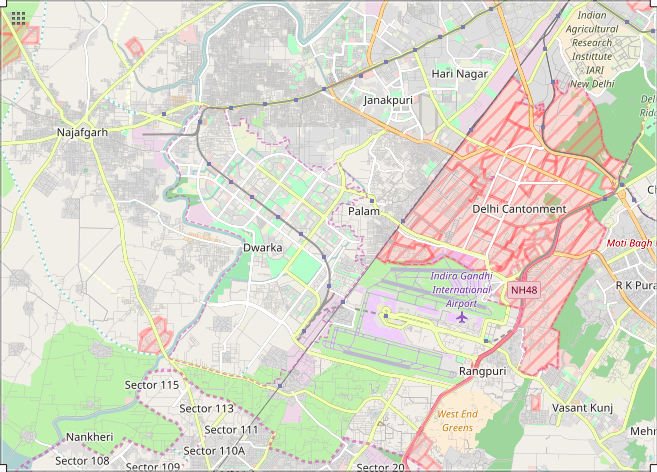

In [1]:
from IPython.display import Image
Image(filename='img.png')

# Part1: Auditing Data

Before we add the dataset into the database, we need to check and see if there is any potential problems.
As the first step of auditing the dataset, let's find out how many kinds of elements there are and the occurrence of each element, to get the feeling on how much of which data we can expect to have in the map.

Ok, then let's go ahead. 
First of all,let's check different tags in the data.

In [2]:
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

start_time = time.time()
tags = count_tags("map")
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in tags.items()], reverse=True)]

print 'Element types and occurrence of data:\n'
pprint.pprint(sorted_by_occurrence)

Element types and occurrence of data:

[('nd', 1614990),
 ('node', 1308649),
 ('tag', 319094),
 ('way', 266288),
 ('member', 23388),
 ('relation', 2932),
 ('osm', 1),
 ('note', 1),
 ('meta', 1),
 ('bounds', 1)]


These are the different tags present above in the data.
Let's check different keys  in the data.

In [3]:
def count_keys(filename):
    keys = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key:
                if key not in keys:
                    keys[key] = 1
                else:
                    keys[key] += 1
    return keys

start_time = time.time()
keys = count_keys("map")
sorted_by_occurrence = [(k, v) for (v, k) in sorted([(value, key) for (key, value) in keys.items()], reverse=True)]

print 'Keys and occurrence in data:\n'
pprint.pprint(sorted_by_occurrence)

Keys and occurrence in data:

[('building', 209176),
 ('highway', 44450),
 ('name', 8487),
 ('surface', 5795),
 ('power', 4558),
 ('landuse', 3027),
 ('type', 2952),
 ('oneway', 2766),
 ('amenity', 2593),
 ('boundary', 2339),
 ('admin_level', 2173),
 ('barrier', 1889),
 ('addr:housenumber', 1875),
 ('leisure', 1588),
 ('railway', 1217),
 ('addr:street', 1212),
 ('addr:postcode', 1102),
 ('addr:city', 1034),
 ('access', 948),
 ('layer', 815),
 ('addr:country', 738),
 ('source', 698),
 ('place', 683),
 ('shop', 680),
 ('bridge', 628),
 ('addr:state', 612),
 ('service', 593),
 ('gauge', 554),
 ('addr:place', 524),
 ('electrified', 493),
 ('lanes', 480),
 ('natural', 445),
 ('voltage', 411),
 ('addr:interpolation', 397),
 ('tourism', 395),
 ('name:en', 379),
 ('aeroway', 363),
 ('ref', 345),
 ('shop:type', 327),
 ('frequency', 327),
 ('owner', 325),
 ('image', 325),
 ('waterway', 293),
 ('maxspeed', 263),
 ('operator', 251),
 ('network', 235),
 ('alt_name', 222),
 ('foot', 213),
 ('shop:si

###### The following function  displays  different keys with their occurrences in the xml data. It is used to check different values of a particular key for auditing purposes.

In [24]:
def keys_with_val(filename,keyv):
    keys = {}
    for event, elem in ET.iterparse(filename, events=('start', 'end')):
        if event == 'end':
            key = elem.attrib.get('k')
            if key==keyv:
                v = elem.attrib.get('v')
                if v not in keys:
                    keys[v] = 1
                else:
                    keys[v]+=1
    return keys

In [5]:
keys_with_val("map","addr:postcode")

{'020626': 1,
 '100006': 59,
 '110 001': 1,
 '110 021': 1,
 '110 067': 1,
 '1100002': 1,
 '110001': 24,
 '1100016': 1,
 '110002': 12,
 '110003': 15,
 '1100049': 1,
 '110005': 5,
 '110006': 10,
 '110007': 3,
 '110008': 3,
 '110010': 5,
 '110011': 4,
 '110014': 2,
 '110015': 5,
 '110016': 16,
 '110017': 15,
 '110018': 8,
 '110019': 4,
 '110021': 9,
 '110022': 1,
 '110023': 2,
 '110024': 7,
 '110026': 2,
 '110029': 11,
 '110030': 3,
 '110034': 4,
 '110035': 4,
 '110037': 3,
 '110041': 1,
 '110043': 13,
 '110045': 8,
 '110047': 1,
 '110048': 10,
 '110049': 3,
 '110052': 4,
 '110054': 4,
 '110055': 21,
 '110057': 2,
 '110058': 8,
 '110059': 3,
 '110060': 1,
 '110062': 2,
 '110063': 10,
 '110064': 2,
 '110065': 1,
 '110066': 1,
 '110067': 16,
 '110070': 28,
 '110072': 1,
 '110074': 2,
 '110075': 55,
 '110077': 4,
 '110078': 1,
 '110080': 1,
 '110085': 1,
 '110087': 509,
 '110092': 2,
 '122001': 95,
 '122002': 13,
 '122009': 1,
 '122010': 1,
 '122016': 5,
 '122017': 4,
 '124507': 16,
 '201301

There are some postcodes that are not valid. For example  all postcodes starting with 12 and more than or less than 6 digits. We need to fix them, which will go into PART -2 of this notebook.

In [10]:
keys_with_val("map","addr:country")

{'IN': 738}

All good here...!!!

In [11]:
keys_with_val("map","addr:city")

{'Bahadurgarh': 16,
 'Bijwasan': 1,
 'Chanakyapuri, New Delhi': 1,
 'DELHI': 2,
 'DLF Phase I': 1,
 'Delh': 1,
 'Delhi': 97,
 'Dwarka': 4,
 'Gurgaon': 116,
 'Gurgaon, Haryana': 1,
 'Gurgram': 2,
 'Gurugram': 10,
 'Janakpuri': 1,
 'Lado Sarai ,new Delhi': 1,
 'Mahavir Enclave': 1,
 'New Delhi': 766,
 'New Delhi, Delhi': 2,
 'New delhi': 1,
 'Noida': 2,
 'Nueva Delhi': 1,
 'Old Delhi': 1,
 'delhi': 5,
 'noida': 1}

We need only city name, not state name. Hence stuff after ','  should be removed.

In [52]:
keys_with_val("map","phone")

{u'(+11) 24682001\u201424682005': 1,
 '(011) - 26542100 - 2196': 1,
 '+ 91 (11) 28741089': 1,
 '+124 6470708': 1,
 '+91 011 24333178': 1,
 '+91 011 40556770': 1,
 '+91 011-40518400': 1,
 '+91 11 2335 6080': 1,
 '+91 11 2336 5358': 1,
 '+91 11 23468300': 1,
 '+91 11 23521362 , 63, 64, 65': 1,
 '+91 11 2397 5464': 1,
 '+91 11 2469-0077': 1,
 '+91 11 25060720': 1,
 '+91 11 2696 0721': 1,
 '+91 11 3041 0098': 1,
 '+91 11 3218206': 1,
 '+91 11 39191919': 1,
 '+91 11 3955 5000': 1,
 '+91 11 41191919': 1,
 '+91 11 412 25666': 1,
 '+91 11 42350000': 1,
 '+91 11 4995 9500': 1,
 '+91 11 6626 1000': 1,
 '+91 1800 208 4376': 1,
 '+91 91365 05467': 1,
 '+91 9172313994': 1,
 '+91 92053 45002': 1,
 '+91 95 60 266255': 1,
 '+91 97 17 896104': 1,
 '+91 97172 58620': 1,
 '+91 98100 77352': 1,
 '+91 9810083705': 1,
 '+91 9911941144, +91 9911921144': 1,
 '+91-11-23340177': 1,
 '+91-11-23543813': 1,
 '+91-11-23561516': 1,
 '+91-11-25227210': 1,
 '+91-11-25437540': 2,
 '+91-11-40771234': 1,
 '+91-11-4102180

# Part-2 : Fixing the above variables

#### Let's start by fixing pincodes. 

We need to remove pincodes  and it's corresponding data because we don't require thatd data.

In [13]:
def get_postcode(elem):
    if elem.tag in ['node', 'way', 'relation']:
        for tag in elem.iter():
            if tag.get('k') == 'addr:postcode':
                return True, tag.get('v')
        return False, None
    return False, None


def clean_postcode(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    regex=re.compile('^12|^20|^02')
    
    for child in ['node', 'way', 'relation']:
        for elem in root.findall(child):
            has_postcode, postcode_value = get_postcode(elem)
            if has_postcode:
                if re.match(regex,postcode_value) or len(postcode_value)!=6:
                    root.remove(elem)
    
    return tree.write(cleaned_filename)

cleaned_postcode = 'cleaned_postcode.xml'
clean_postcode("map", cleaned_postcode)
    

Now,let's check if th file still contains those postcodes.

In [16]:
keys_with_val('cleaned_postcode.xml','addr:postcode')

{'100006': 59,
 '110001': 24,
 '110002': 12,
 '110003': 15,
 '110005': 5,
 '110006': 10,
 '110007': 3,
 '110008': 3,
 '110010': 5,
 '110011': 4,
 '110014': 2,
 '110015': 5,
 '110016': 16,
 '110017': 15,
 '110018': 8,
 '110019': 4,
 '110021': 9,
 '110022': 1,
 '110023': 2,
 '110024': 7,
 '110026': 2,
 '110029': 11,
 '110030': 3,
 '110034': 4,
 '110035': 4,
 '110037': 3,
 '110041': 1,
 '110043': 13,
 '110045': 8,
 '110047': 1,
 '110048': 10,
 '110049': 3,
 '110052': 4,
 '110054': 4,
 '110055': 21,
 '110057': 2,
 '110058': 8,
 '110059': 3,
 '110060': 1,
 '110062': 2,
 '110063': 10,
 '110064': 2,
 '110065': 1,
 '110066': 1,
 '110067': 16,
 '110070': 28,
 '110072': 1,
 '110074': 2,
 '110075': 55,
 '110077': 4,
 '110078': 1,
 '110080': 1,
 '110085': 1,
 '110087': 509,
 '110092': 2}

As we can see, the post code values are fixed.

##### Now let's change city names

In [27]:
def clean_city(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for child in ['node', 'way', 'relation']:
        for elem in root.findall(child):
            if elem.tag in ['node', 'way', 'relation']:
                for tag in elem.iter():
                    if tag.get('k') == 'addr:city':
                        val = tag.get('v').split(",")[0]
                        tag.attrib['v'] = val 
    return tree.write(cleaned_filename)

cleaned_city = 'cleaned_city.xml'
clean_city("cleaned_postcode.xml", cleaned_city)

In [30]:
keys_with_val("cleaned_city.xml","addr:city")

{'Bijwasan': 1,
 'Chanakyapuri': 1,
 'DELHI': 2,
 'DLF Phase I': 1,
 'Delh': 1,
 'Delhi': 97,
 'Dwarka': 4,
 'Gurgaon': 7,
 'Gurgram': 1,
 'Gurugram': 4,
 'Janakpuri': 1,
 'Lado Sarai ': 1,
 'Mahavir Enclave': 1,
 'New Delhi': 762,
 'New delhi': 1,
 'Nueva Delhi': 1,
 'Old Delhi': 1,
 'delhi': 5}

#####  Let's fix some phone numbers

I am using google library phonenumbers for parsing and cleaning phone numbers .

In [70]:
def proces_phone(number):
    try:
        parsed = phonenumbers.parse(number)
        return str(parsed.national_number)[0:-1]
    except:
        return number
        pass
    
def clean_phone(filename, cleaned_filename):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    for child in ['node', 'way', 'relation']:
        for elem in root.findall(child):
            if elem.tag in ['node', 'way', 'relation']:
                for tag in elem.iter():
                    if tag.get('k') == 'phone':
                        val = proces_phone(tag.get('v'))
                        tag.attrib['v'] = val 
    return tree.write(cleaned_filename)

cleaned_phone = 'cleaned_phone.xml'
clean_phone("cleaned_city.xml", cleaned_phone)


In [71]:
keys_with_val("cleaned_phone.xml","phone")

{'(011) - 26542100 - 2196': 1,
 '+91 11 23521362 , 63, 64, 65': 1,
 '+91 9911941144, +91 9911921144': 1,
 '+91-120-3830000; +91-11-23582812 / 4658': 1,
 '+91911180965;+918285093982;+919015847464': 1,
 '011 2332 8589': 1,
 '011 2688 1737': 1,
 '011 2790 7000': 1,
 '011 41037878': 1,
 '011 41541340': 1,
 '011 42502294': 1,
 '011 4678 6786': 1,
 '011-27010377': 1,
 '01123416434': 1,
 '011235583563': 1,
 '01129533186': 1,
 '01141017360': 1,
 '01141706720': 1,
 '01143663333': 1,
 '01149977000': 1,
 '02261220220': 1,
 '083778 40776': 1,
 '09818802760': 1,
 '112334017': 1,
 '112335608': 1,
 '112336535': 1,
 '112346830': 1,
 '112354381': 1,
 '112356151': 1,
 '112358910': 1,
 '112397546': 1,
 '112433317': 1,
 '112469007': 1,
 '112506072': 1,
 '112522721': 1,
 '112543754': 2,
 '112659713': 1,
 '112680180': 1,
 '112696072': 1,
 '112808880': 1,
 '112874108': 1,
 '113041009': 1,
 '11321820': 1,
 '113919191': 1,
 '113955500': 1,
 '114004700': 1,
 '114026770': 1,
 '114051840': 1,
 '114055677': 1,
 '1

## Part-3 : Importing into Database

We've cleaned the phone numbers. The cleaned xml file is now cleaned_phone.xml. We'll convert this file to JSON and use it in MongoDB database.


In [72]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

In [73]:
def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way":
        node['type'] = element.tag

        # Parse attributes
        for a in element.attrib:
            if a in CREATED:
                if 'created' not in node:
                    node['created'] = {}
                node['created'][a] = element.attrib[a]

            elif a in ['lat', 'lon']:
                if 'pos' not in node:
                    node['pos'] = [None, None]
                if a == 'lat':
                    node['pos'][0] = float(element.attrib[a])
                else:
                    node['pos'][1] = float(element.attrib[a])

            else:
                node[a] = element.attrib[a]

        # Iterate tag children
        for tag in element.iter("tag"):
            if not problemchars.search(tag.attrib['k']):
                # Tags with single colon
                if lower_colon.search(tag.attrib['k']):

                    # Single colon beginning with addr
                    if tag.attrib['k'].find('addr') == 0:
                        if 'address' not in node:
                            node['address'] = {}

                        sub_attr = tag.attrib['k'].split(':', 1)
                        node['address'][sub_attr[1]] = tag.attrib['v']

                    # All other single colons processed normally
                    else:
                        node[tag.attrib['k']] = tag.attrib['v']

                # Tags with no colon
                elif tag.attrib['k'].find(':') == -1:
                    node[tag.attrib['k']] = tag.attrib['v']

            # Iterate nd children
            for nd in element.iter("nd"):
                if 'node_refs' not in node:
                    node['node_refs'] = []
                node['node_refs'].append(nd.attrib['ref'])

        return node
    else:
        return None

In [75]:
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

In [76]:
process_map('cleaned_phone.xml')

[{'admin_level': '2',
  'capital': 'yes',
  'created': {'changeset': '46299189',
   'timestamp': '2017-02-22T08:42:55Z',
   'uid': '3029661',
   'user': 'saikabhi',
   'version': '53'},
  'id': '16173236',
  'is_capital': 'country',
  'is_in': 'National Capital Region, NCR, India',
  'is_in:continent': 'Asia',
  'is_in:country': 'India',
  'is_in:country_code': 'IN',
  'name': 'New Delhi',
  'name:ace': 'New delhi',
  'name:af': 'Nieu-Delhi',
  'name:am': u'\u1292\u12cd \u12f4\u120a',
  'name:an': 'Nueva Delhi',
  'name:ang': u'N\u012b\u01bfe Delhi',
  'name:ar': u'\u0646\u064a\u0648\u062f\u0644\u0647\u064a',
  'name:be': u'\u041d\u044c\u044e-\u0414\u044d\u043b\u0456',
  'name:bg': u'\u041d\u044e \u0414\u0435\u043b\u0445\u0438',
  'name:bn': u'\u09a8\u09a4\u09c1\u09a8 \u09a6\u09bf\u09b2\u09cd\u09b2\u09bf',
  'name:bo': u'\u0f53\u0f7a\u0f60\u0f74\u0f0b\u0f51\u0f72\u0f63\u0f0b\u0f63\u0f72\u0f0d',
  'name:bpy': u'\u09a8\u09c1\u09f1\u09be \u09a6\u09bf\u09b2\u09cd\u09b2\u09c0',
  'name:br':